In [28]:
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os


import albumentations as A
alb_aug = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=5, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.02, rotate_limit=0, p=0.2),
    A.Normalize()
])


class AlbumentationsDataGenerator(Sequence):
    def __init__(self, directory, batch_size=32, target_size=(224, 224), shuffle=True, aug=None):
        self.directory = directory
        self.batch_size = batch_size
        self.target_size = target_size
        self.aug = aug
        self.shuffle = shuffle

        self.class_indices = {cls: i for i, cls in enumerate(os.listdir(directory))}
        self.filepaths = []
        for cls in self.class_indices:
            cls_path = os.path.join(directory, cls)
            for f in os.listdir(cls_path):
                if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.filepaths.append((os.path.join(cls_path, f), self.class_indices[cls]))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.filepaths) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.filepaths)
    
    def __getitem__(self, idx):
        batch_paths = self.filepaths[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, labels = [], []
        for path, label in batch_paths:
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.target_size)
            if self.aug:
                img = self.aug(image=img)['image']
            images.append(img)
            labels.append(label)
        return np.array(images, dtype=np.float32), np.array(labels)


train_gen = AlbumentationsDataGenerator(
    'resnet_dataset/train', batch_size=32, target_size=(224, 224), aug=alb_aug
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    'resnet_dataset/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

print("\nData generators ready!")


Found 194 images belonging to 2 classes.

Data generators ready!


C:\Users\asmit\anaconda3\envs\malnutrition\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


# **Step 5: Model Training**

We will train a **ResNet50 model** (pre-trained on ImageNet) using transfer learning:
- The base layers of ResNet50 are frozen to leverage pre-trained features.
- Custom dense layers are added for binary classification (healthy vs malnourished).
- The model is trained with **Adam optimizer**, **binary cross-entropy loss**, and **real-time augmented images** for improved accuracy.


In [29]:

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# Callbacks
checkpoint = ModelCheckpoint('best_resnet50.h5', monitor='accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)


history = model.fit(
    train_gen,
    epochs=30,
    callbacks=[checkpoint, early_stop]
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

C:\Users\asmit\anaconda3\envs\malnutrition\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4732 - loss: 0.9330

24/24 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.4749 - loss: 0.9303
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6304 - loss: 0.6642

24/24 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.6318 - loss: 0.6629
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7505 - loss: 0.5139

24/24 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.7513 - loss: 0.5130
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8015 - loss: 0.4569

24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8005 - loss: 0.4578
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7928 - loss: 0.4430

24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.7934 - loss: 0.4425
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8093 - loss: 0.4157

24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8095 - loss: 0.4157
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8251 - loss: 0.4155
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8430 - loss: 0.3678

24/24 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8421 - loss: 0.3687
Epoch 9/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8383 - loss: 0.3874

24/24 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8382 - loss: 0.3876
Epoch 10/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8563 - loss: 0.3642

24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8561 - loss: 0.3649
Epoch 11/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8154 - loss: 0.3904
Epoch 12/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8508 - loss: 0.3467
Epoch 13/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8607 - loss: 0.3538
Epoch 14/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8598 - loss: 0.3409

24/24 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8596 - loss: 0.3407
Epoch 15/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8630 - loss: 0.3611

24/24 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.8631 - loss: 0.3607
Epoch 16/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8257 - loss: 0.3723
Epoch 17/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8580 - loss: 0.3299
Epoch 18/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8576 - loss: 0.3222
Epoch 19/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8700 - loss: 0.3195

24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8699 - loss: 0.3194
Epoch 20/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8788 - loss: 0.3142

24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8787 - loss: 0.3138
Epoch 21/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8633 - loss: 0.3236
Epoch 22/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8739 - loss: 0.3083
Epoch 23/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8679 - loss: 0.3445
Epoch 24/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8417 - loss: 0.3190
Epoch 25/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8915 - loss: 0.2848
Epoch 26/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8949 - loss: 0.2763

24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8945 - loss: 0.2767
Epoch 27/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8660 - loss: 0.3073
Epoch 28/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8773 - loss: 0.3160
Epoch 29/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8688 - loss: 0.2986
Epoch 30/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8668 - loss: 0.2923


**Accuracy after Fine Tuning**

In [30]:
from tensorflow.keras.models import load_model


model = load_model('best_resnet50.h5')


for layer in model.layers[-30:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):  
        layer.trainable = True


model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])


checkpoint_finetune = ModelCheckpoint('best_resnet50_finetuned.h5', monitor='accuracy', save_best_only=True, mode='max')
early_stop_finetune = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)


history_finetune = model.fit(
    train_gen,
    epochs=20,
    callbacks=[checkpoint_finetune, early_stop_finetune]
)


model.save('final_resnet50_model.keras')
print("Fine-tuning complete. Model saved as final_resnet50_model.keras")


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8785 - loss: 0.3094

24/24 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.8782 - loss: 0.3096
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8966 - loss: 0.2347

24/24 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.8966 - loss: 0.2353
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8979 - loss: 0.2344

24/24 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.8979 - loss: 0.2342
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9103 - loss: 0.2180

24/24 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.9100 - loss: 0.2183
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9166 - loss: 0.2300

24/24 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.9172 - loss: 0.2285
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.9226 - loss: 0.1827
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9440 - loss: 0.1385

24/24 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.9437 - loss: 0.1390
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9308 - loss: 0.1441

24/24 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.9314 - loss: 0.1437
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9391 - loss: 0.1590

24/24 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.9394 - loss: 0.1579
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9533 - loss: 0.1269

24/24 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.9533 - loss: 0.1270
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9727 - loss: 0.0777

24/24 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.9725 - loss: 0.0778
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9673 - loss: 0.0801

24/24 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.9674 - loss: 0.0798
Epoch 13/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9682 - loss: 0.0772

24/24 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.9685 - loss: 0.0768
Epoch 14/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.9685 - loss: 0.0813
Epoch 15/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9829 - loss: 0.0607

24/24 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.9830 - loss: 0.0603
Epoch 16/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.9673 - loss: 0.0595
Epoch 17/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9855 - loss: 0.0370

24/24 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.9856 - loss: 0.0368
Epoch 18/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.9854 - loss: 0.0320
Epoch 19/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.9875 - loss: 0.0359
Epoch 20/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.9825 - loss: 0.0310
Fine-tuning complete. Model saved as final_resnet50_model.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.7411 - loss: 3.1509
Test Accuracy after fine-tuning: 51.03%
Test Loss after fine-tuning: 5.9627


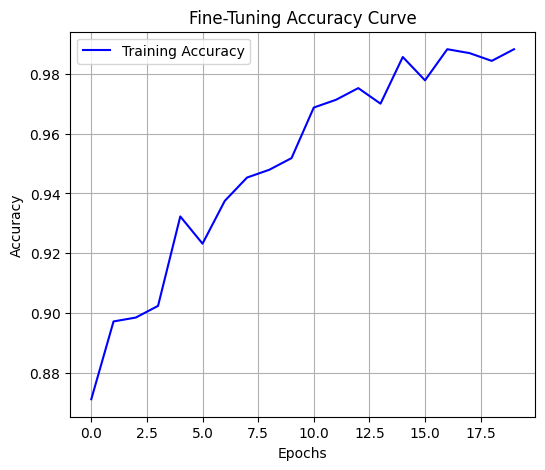

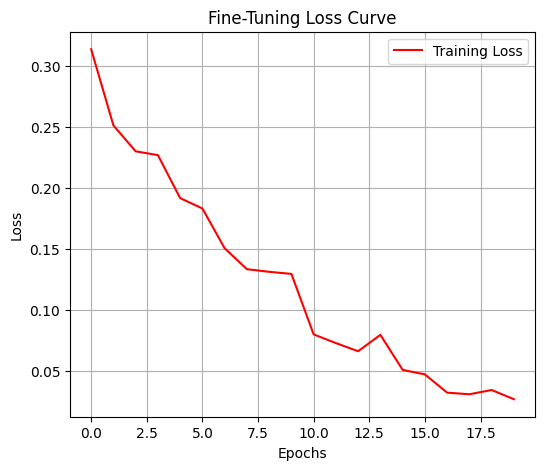

7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


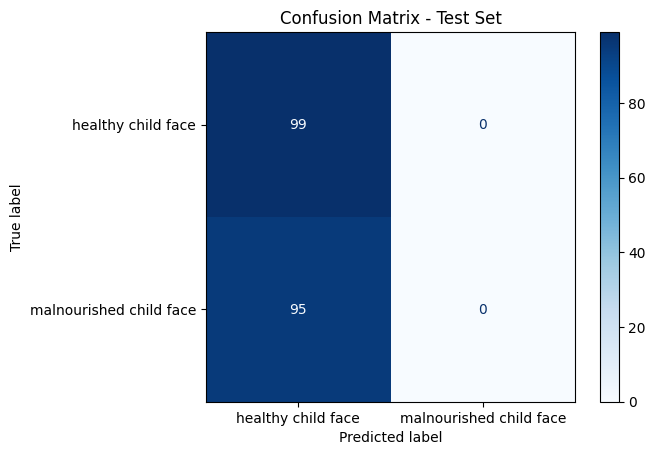

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Evaluate on test set
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy after fine-tuning: {test_acc * 100:.2f}%")
print(f"Test Loss after fine-tuning: {test_loss:.4f}")

# 2. Plot accuracy curve (fine-tuning)
plt.figure(figsize=(6, 5))
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy', color='blue')
plt.title('Fine-Tuning Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# 3. Plot loss curve (fine-tuning)
plt.figure(figsize=(6, 5))
plt.plot(history_finetune.history['loss'], label='Training Loss', color='red')
plt.title('Fine-Tuning Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 4. Confusion Matrix
y_pred = model.predict(test_gen)
y_pred_labels = (y_pred > 0.5).astype(int).ravel()

cm = confusion_matrix(test_gen.classes, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_gen.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()


In [32]:
from tensorflow.keras.models import load_model
model = load_model('best_resnet50.h5')
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy of pre-fine-tuned model: {test_acc * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.7411 - loss: 1.0199
Test Accuracy of pre-fine-tuned model: 51.03%
